<a href="https://colab.research.google.com/github/UMassIonTrappers/quantum-computing-labs/blob/main/Lab_07_Quantum_circuits_quantum_adder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 550/650 QC

## Introduction to Quantum Computing

Robert Niffenegger (rniffenegger@umass.edu )

In [2]:
try:
  import qutip
except ImportError:
  print('Install Qutip')
  !pip install qutip
  '''New library from Qutip https://arxiv.org/pdf/2105.09902v2.pdf '''
  !pip install --quiet qutip-qip

try:
  import qiskit
except ImportError:
  print('Install Qiskit')
  !pip install -q qiskit
  !pip install -q qiskit[visualization]
  !pip install --quiet qiskit_ibm_provider[visualization]
  !pip install --quiet qiskit-ibm-runtime
  # !pip install -q git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

In [3]:
try:
  from qiskit_aer import QasmSimulator
  print('Qiskit Aer imported');
except ImportError:
  print('Install Qiskit-Aer')
  !pip install --quiet qiskit-aer

Qiskit Aer imported


### Initialize

In [1]:
%matplotlib inline
from IPython.display import display, Math
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt, sin, cos

#Plot setup
from pylab import *
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

#QuTiP imports
import qutip as qt
from qutip import *

#QUTIP QIP
from qutip.qip import *
from qutip_qip.circuit import QubitCircuit
from qutip_qip.operations import Gate
from qutip_qip.qasm import circuit_to_qasm_str

#Qisket imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city
from qiskit_aer import QasmSimulator

from qiskit.quantum_info import Statevector
'''
In Jupyter Notebooks we can display this nicely using Latex.
'''
from qiskit.visualization import array_to_latex


# LAB 13 - QEC - Surface Codes and Color Codes

We know what our qubits are prone to error and that their loss of information to bit flips and phase errors are just a matter of time...

But what if we can store the information of one qubit redundantly in other qubits.

This would allow us to encode a new logical qubit in the physical qubits.

We can then use this logical qubit to encode information and perform quantum operations.






## Overview

Surface codes and color codes are topological quantum error correction codes that are considered among the most promising approaches for practical quantum computing. This lab explores their structure, implementation, and error correction capabilities.

### Learning Objectives
By the end of this lab, you will be able to:
1. Understand the structure of surface and color codes
2. Implement stabilizer measurements
3. Perform error detection and correction
4. Compare the performance of different code layouts

### Prerequisites
- Understanding of stabilizer formalism
- Familiarity with basic quantum error correction
- Knowledge of graph theory basics

### Required Reading
- [Surface Codes: Towards Practical Large-Scale Quantum Computation](https://arxiv.org/abs/1208.0928)
- [Color Code Tutorial](https://quantum-journal.org/papers/q-2018-09-03-87/)

In [ ]:
'''Install required packages'''
# !pip install networkx

# Import necessary libraries
import networkx as nx


## Part 1: The Surface Code

The surface code is a stabilizer code defined on a 2D lattice where:
- Data qubits live on edges
- X-type stabilizers are associated with vertices
- Z-type stabilizers are associated with plaquettes

Let's start by implementing a distance-3 surface code (requiring 13 data qubits).

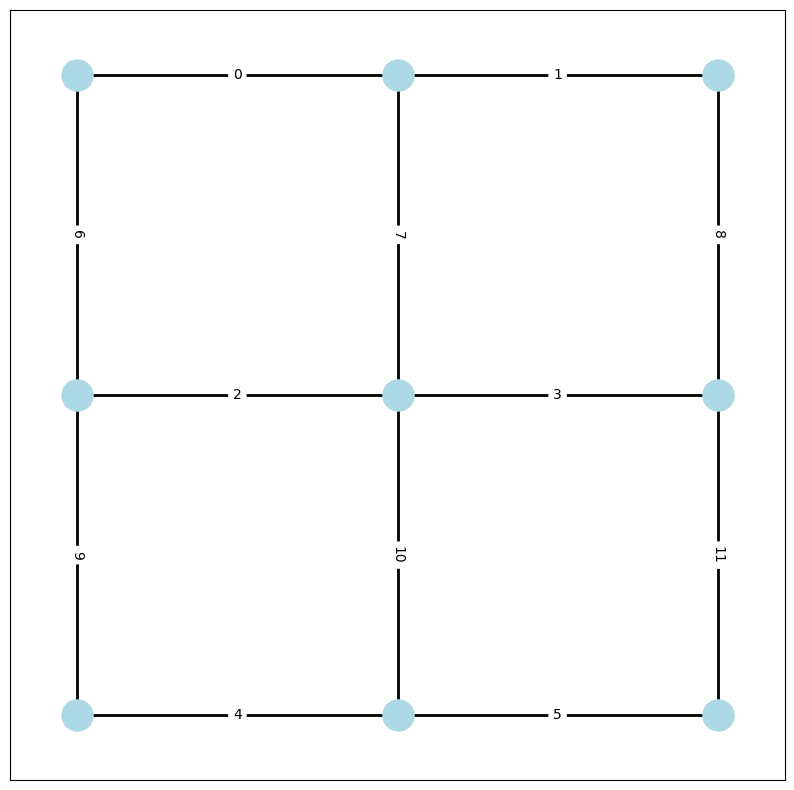

In [5]:
class SurfaceCode:
    def __init__(self, distance):
        """Initialize a surface code with given distance
        
        Args:
            distance (int): Code distance (odd integer ≥ 3)
        """
        self.d = distance
        self.n_data = distance**2 + (distance-1)**2  # Number of data qubits
        self.n_stabilizers = 2 * (distance-1)**2  # Number of stabilizer generators
        
        # Create graph representation
        self.graph = self._create_lattice()
        
    def _create_lattice(self):
        """Create the surface code lattice"""
        G = nx.Graph()
        
        # Add data qubits (edges)
        qubit_idx = 0
        for i in range(self.d):
            for j in range(self.d-1):
                # Horizontal edges
                G.add_edge((i,j), (i,j+1), qubit=qubit_idx)
                qubit_idx += 1
                
        for i in range(self.d-1):
            for j in range(self.d):
                # Vertical edges
                G.add_edge((i,j), (i+1,j), qubit=qubit_idx)
                qubit_idx += 1
        
        return G
    
    def draw_lattice(self):
        """Visualize the surface code lattice"""
        pos = {(i,j): (j,-i) for i,j in self.graph.nodes()}
        
        plt.figure(figsize=(10,10))
        # Draw edges (data qubits)
        nx.draw_networkx_edges(self.graph, pos, width=2)
        
        # Draw vertices
        nx.draw_networkx_nodes(self.graph, pos, node_color='lightblue',
                              node_size=500)
        
        # Add labels
        edge_labels = nx.get_edge_attributes(self.graph, 'qubit')
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels)
        
        plt.axis('equal')
        plt.show()

# Create and visualize a distance-3 surface code
code = SurfaceCode(3)
code.draw_lattice()

### Exercise 1.1: Stabilizer Measurements

Implement the circuits for measuring X and Z stabilizers in the surface code. Each stabilizer involves either:
- X operators on all data qubits around a vertex (star operator)
- Z operators on all data qubits around a plaquette (plaquette operator)

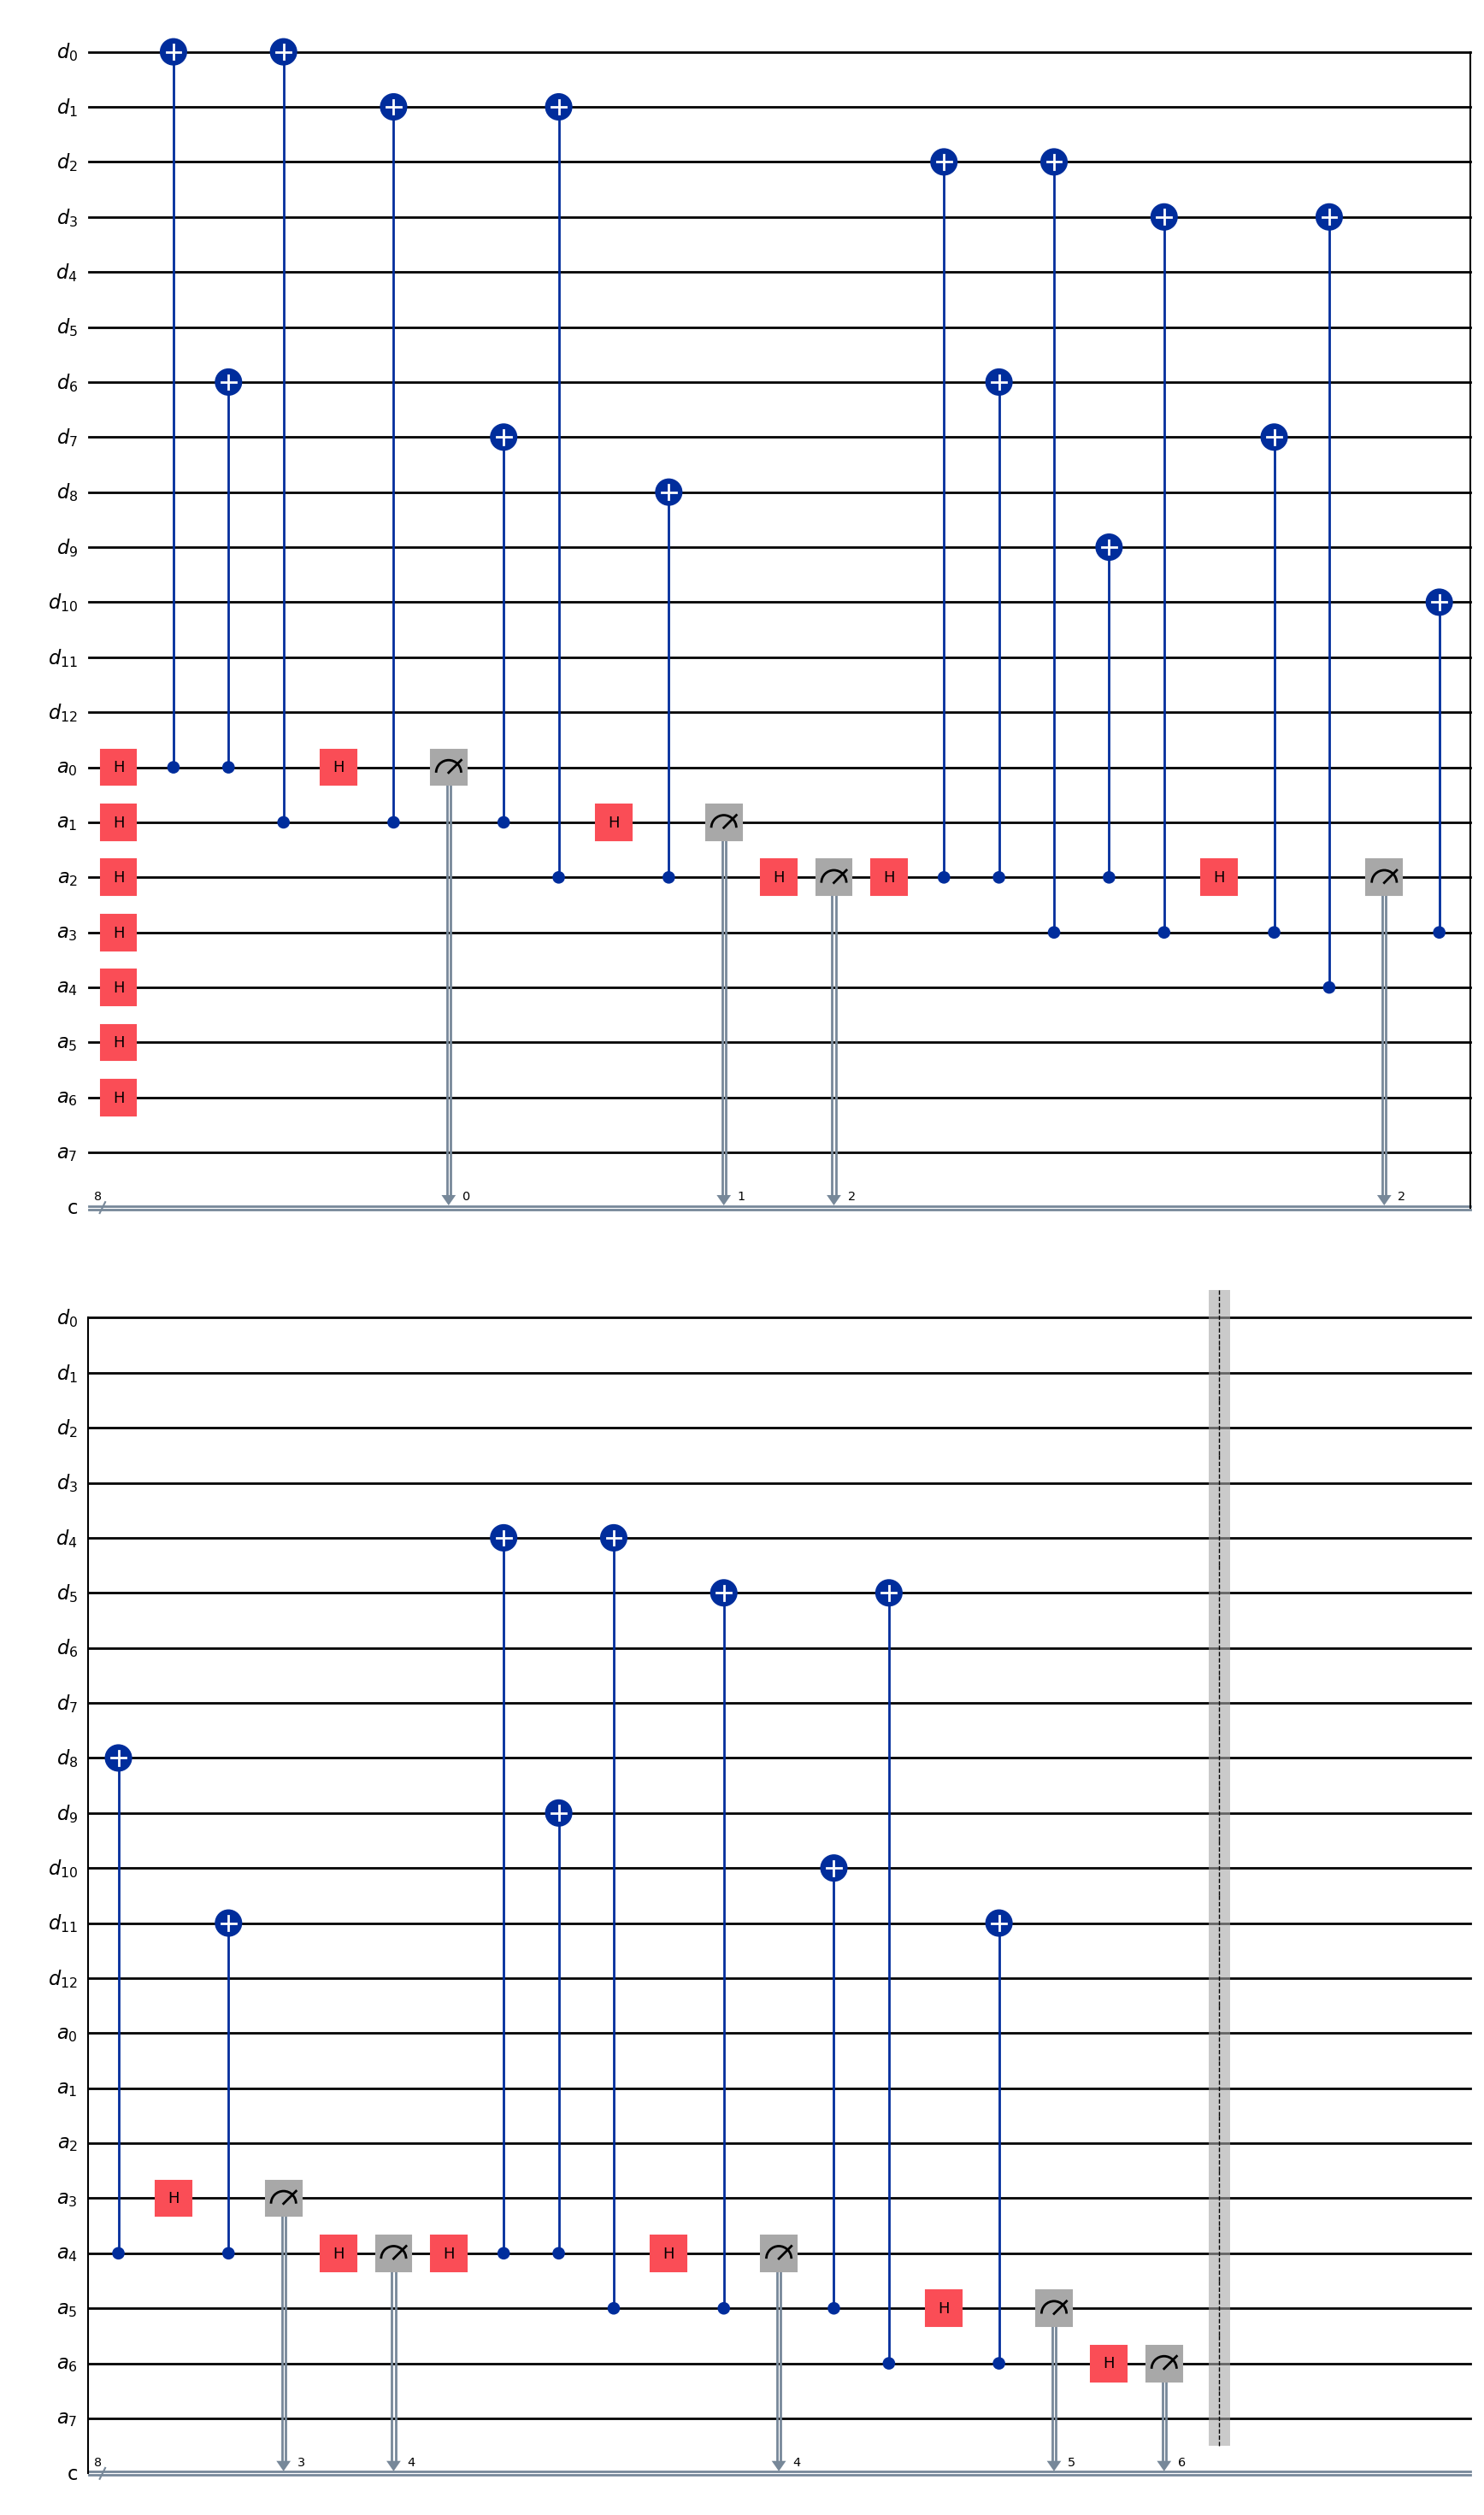

In [7]:
def create_stabilizer_circuits(code):
    """Create circuits for all stabilizer measurements
    
    Args:
        code (SurfaceCode): Surface code instance
    """
    # Create quantum registers
    data = QuantumRegister(code.n_data, 'd')
    anc = QuantumRegister(code.n_stabilizers, 'a')
    c = ClassicalRegister(code.n_stabilizers, 'c')
    qc = QuantumCircuit(data, anc, c)
    
    # Add X-type stabilizer measurements (vertices)
    for vertex in code.graph.nodes():
        neighbors = list(code.graph.neighbors(vertex))
        if len(neighbors) > 0:  # Skip boundary vertices
            # Initialize ancilla in |+⟩ state
            anc_idx = vertex[0] * (code.d-1) + vertex[1]
            qc.h(anc[anc_idx])
            
            # Apply CNOT gates
            for neighbor in neighbors:
                edge_data = code.graph[vertex][neighbor]
                qc.cx(anc[anc_idx], data[edge_data['qubit']])
            
            # Measure ancilla
            qc.h(anc[anc_idx])
            qc.measure(anc[anc_idx], c[anc_idx])
    
    qc.barrier()
    
    # Add Z-type stabilizer measurements (plaquettes)
    # Similar structure but with CZ gates instead of CNOT
    
    return qc

# Create and display stabilizer circuits
stabilizer_circuit = create_stabilizer_circuits(code)
stabilizer_circuit.draw('mpl')

## Part 2: The Color Code

Color codes are defined on 3-colorable lattices where:
- Data qubits live on vertices
- Stabilizers are associated with faces
- Each face has both X and Z type stabilizers

Let's implement a 7-qubit color code (the Steane code).

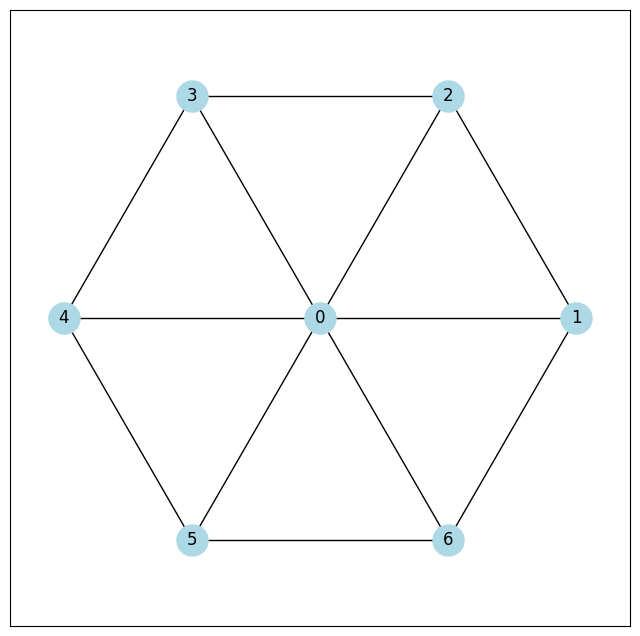

In [8]:
class ColorCode:
    def __init__(self):
        """Initialize the 7-qubit color code"""
        self.n_data = 7
        self.n_stabilizers = 6  # 3 faces × 2 types (X/Z)
        
        # Create graph representation
        self.graph = self._create_steane_lattice()
        
    def _create_steane_lattice(self):
        """Create the Steane code lattice"""
        G = nx.Graph()
        
        # Add vertices (data qubits)
        positions = {
            0: (0, 0),    # Center
            1: (1, 0),    # Right
            2: (0.5, 0.866),  # Top right
            3: (-0.5, 0.866), # Top left
            4: (-1, 0),   # Left
            5: (-0.5, -0.866), # Bottom left
            6: (0.5, -0.866)  # Bottom right
        }
        
        for i in range(7):
            G.add_node(i, pos=positions[i])
            
        # Add edges to show connectivity
        edges = [(0,1), (0,2), (0,3), (0,4), (0,5), (0,6),
                 (1,2), (2,3), (3,4), (4,5), (5,6), (6,1)]
        G.add_edges_from(edges)
        
        return G
    
    def draw_lattice(self):
        """Visualize the color code lattice"""
        pos = nx.get_node_attributes(self.graph, 'pos')
        
        plt.figure(figsize=(8,8))
        # Draw vertices (data qubits)
        nx.draw_networkx_nodes(self.graph, pos, node_color='lightblue',
                              node_size=500)
        
        # Draw edges
        nx.draw_networkx_edges(self.graph, pos)
        
        # Add labels
        labels = {i: str(i) for i in range(7)}
        nx.draw_networkx_labels(self.graph, pos, labels)
        
        plt.axis('equal')
        plt.show()

# Create and visualize the Steane code
steane = ColorCode()
steane.draw_lattice()

### Exercise 2.1: Color Code Stabilizers

Implement the stabilizer measurements for the color code. Each face has:
1. An X-type stabilizer (product of X operators)
2. A Z-type stabilizer (product of Z operators)

The Steane code has three faces, each involving four qubits.

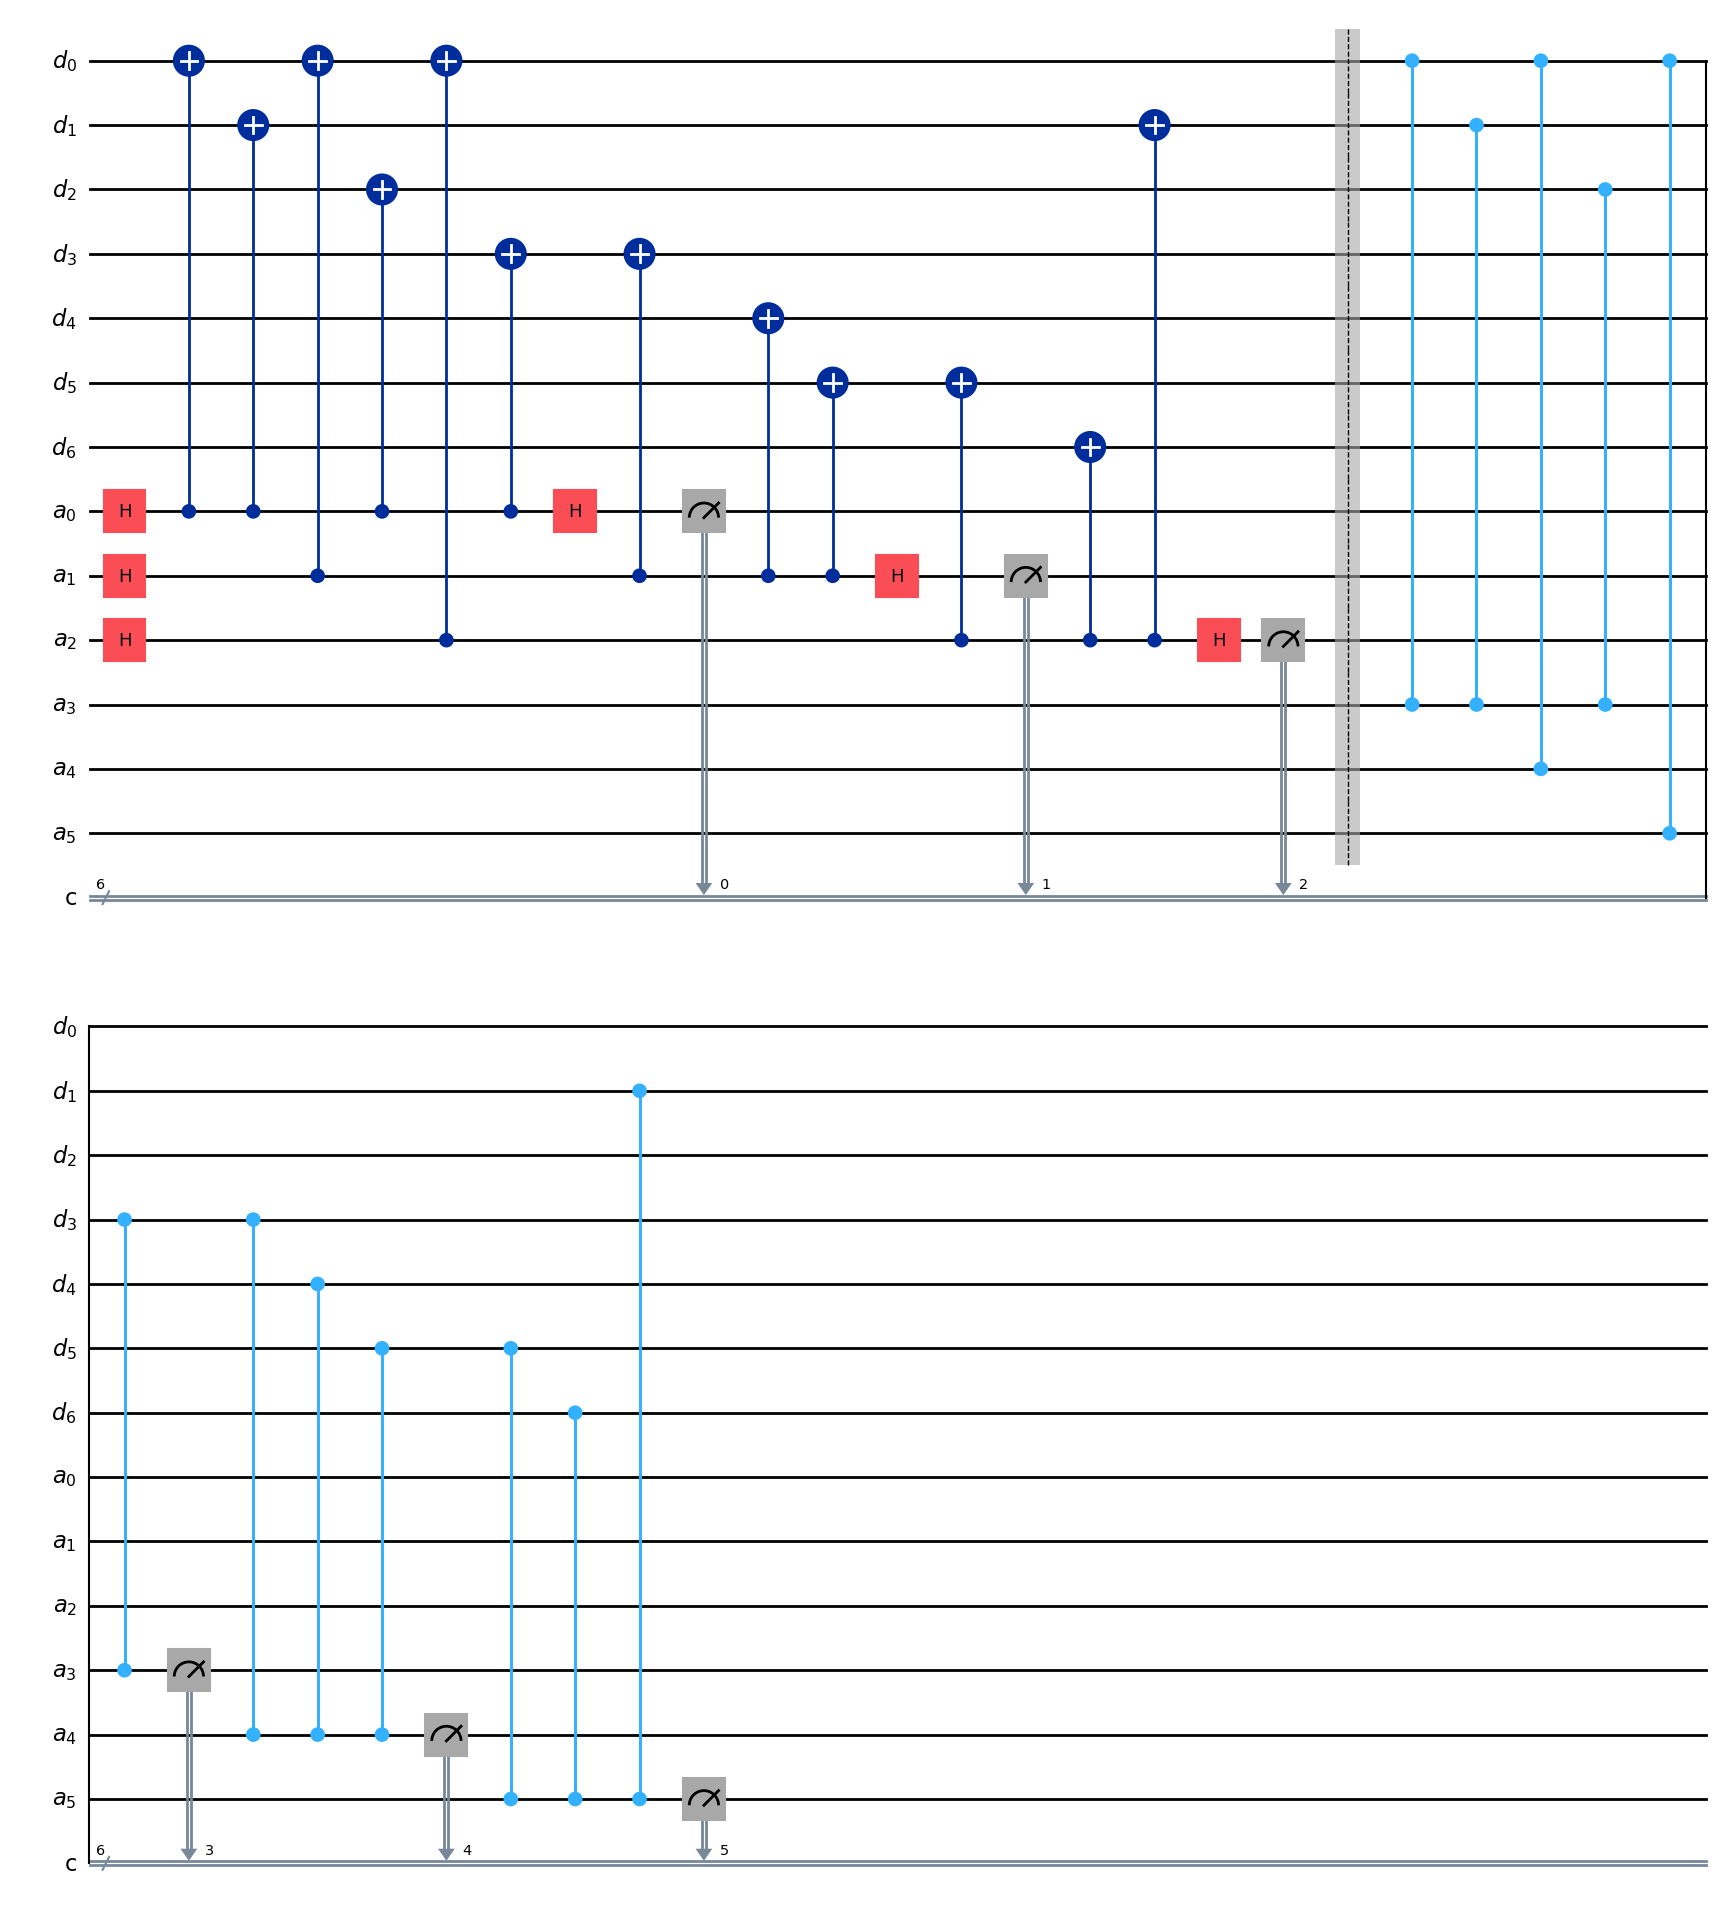

In [10]:
def create_color_code_circuit():
    """Create the full color code circuit with stabilizer measurements"""
    # Quantum registers
    data = QuantumRegister(7, 'd')
    anc = QuantumRegister(6, 'a')  # 3 faces × 2 types
    c = ClassicalRegister(6, 'c')
    qc = QuantumCircuit(data, anc, c)
    
    # Define the faces (stabilizer groups)
    faces = [
        [0, 1, 2, 3],  # First face
        [0, 3, 4, 5],  # Second face
        [0, 5, 6, 1]   # Third face
    ]
    
    # Measure X-type stabilizers
    for i, face in enumerate(faces):
        # Initialize ancilla
        qc.h(anc[i])
        
        # Apply CNOT gates
        for qubit in face:
            qc.cx(anc[i], data[qubit])
        
        # Measure
        qc.h(anc[i])
        qc.measure(anc[i], c[i])
    
    qc.barrier()
    
    # Measure Z-type stabilizers
    for i, face in enumerate(faces):
        # Apply CZ gates
        for qubit in face:
            qc.cz(anc[i+3], data[qubit])
        
        # Measure
        qc.measure(anc[i+3], c[i+3])
    
    return qc

# Create and display the circuit
color_circuit = create_color_code_circuit()
color_circuit.draw('mpl')

## Analysis Questions

1. Compare the resource requirements of surface codes and color codes.
2. How does the code distance relate to the number of physical qubits in each case?
3. What are the advantages and disadvantages of each code?
4. How would you implement logical operations in each code?

## Additional Challenges

1. Implement logical Pauli operations for both codes
2. Simulate error detection and correction
3. Calculate the pseudo-threshold for small distances
4. Design a decoder for either code

## References

1. [Surface Code Review](https://arxiv.org/abs/1208.0928)
2. [Color Codes](https://arxiv.org/abs/1311.0879)
3. [Quantum Error Correction: An Introductory Guide](https://arxiv.org/abs/1907.11157)